In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [11]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [12]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [14]:
# RandomizedSearchCV
# 1. 因为是sklearn的接口，转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    # 因为不知道第一个输入的shape是多大的，因此我们需要单独从for循环里拿出来，for循环里的是输出再次作为输入？
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

# KerasRegressor返回一个sk的model,build_fn是一个回调函数（等一会调用的函数）？
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
# 下面只是先对sk封装tf模型的一个测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.3242 - val_loss: 0.7363
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6511 - val_loss: 0.6572
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6077 - val_loss: 0.6047
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5405 - val_loss: 0.5599
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5072 - val_loss: 0.5359
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5000 - val_loss: 0.5217
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4918 - val_loss: 0.5057
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4699 - val_loss: 0.4792
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4453 - val_loss: 0.4717
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4438 - val_loss: 0.4612

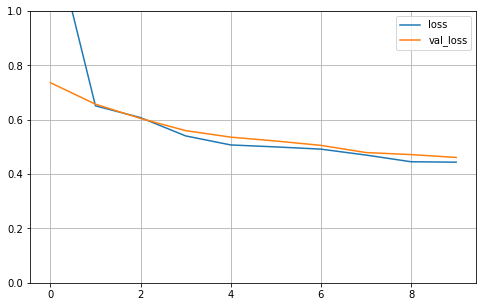

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [16]:
# scipy也是sk中的
from scipy.stats import reciprocal
# 分布函数
# f(x) = 1/(x*log(b/a)) a <= x <= b

# sk 0.21.3版本可以用这种列表
# param_distribution = {
#     "hidden_layers":[1, 2, 3, 4],
#     "layer_size": np.arange(1, 100),
#     "learning_rate": reciprocal(1e-4, 1e-2),
# }
#最新版本只能用普通列表
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": [5, 10, 20, 30],
    "learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#随机搜索
# random_search_cv = RandomizedSearchCV(sklearn_model,
#                                       param_distribution)
grid_search_cv =GridSearchCV(sklearn_model,param_distribution)
# random_search_cv.fit(x_train_scaled, y_train, epochs = 5,
#                      validation_data = (x_valid_scaled, y_valid),
#                      callbacks = callbacks)

grid_search_cv.fit(x_train_scaled, y_train, epochs = 5,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)
# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.6480 - val_loss: 5.2789
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.6703 - val_loss: 4.4621
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.9904 - val_loss: 3.8723
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4864 - val_loss: 3.4233
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.0020
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.6575 - val_loss: 5.5284
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.9985 - val_loss: 4.9229
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4885 - val_loss: 4.4487
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 4.0827 - val_loss: 4.0694
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.6188
Epoch 1/5
291/291 [==============================] -

291/291 [==============================] - 1s 2ms/step - loss: 0.8753 - val_loss: 0.9174
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.8205
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2880 - val_loss: 0.8070
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6902 - val_loss: 0.6880
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6186 - val_loss: 0.6319
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5773 - val_loss: 0.5924
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4847
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2693 - val_loss: 0.7350
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6411 - val_loss: 0.6399
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5788 - val_loss: 0.5933
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 7.2376 - val_loss: 6.5099
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.3942 - val_loss: 5.0049
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.2207 - val_loss: 4.0120
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4290 - val_loss: 3.3306
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.6406
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 9.1416 - val_loss: 8.8108
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 7.7951 - val_loss: 7.5728
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 6.7383 - val_loss: 6.5878
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 5.8911 - val_loss: 5.7929
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 4.6835
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.5606 - val_loss: 0.5842
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.5318
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.1125 - val_loss: 0.7098
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5818 - val_loss: 0.5838
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5270 - val_loss: 0.5428
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.5133
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4779
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0148 - val_loss: 0.6845
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6083 - val_loss: 0.6146
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5471 - val_loss: 0.5676
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 4.1191 - val_loss: 3.8570
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4682 - val_loss: 3.2637
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.9457 - val_loss: 2.7861
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.5239 - val_loss: 2.4027
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.9948
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.5162 - val_loss: 4.5259
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.1035 - val_loss: 4.1254
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7436 - val_loss: 3.7722
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4272 - val_loss: 3.4583
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.9231
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.4556 - val_loss: 0.4583
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4166
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2569 - val_loss: 2.4824
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 10.1964 - val_loss: 0.7763
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 10.3703 - val_loss: 1.2215
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 2.0531
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.5930
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 6.8734 - val_loss: 0.5609
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4860 - val_loss: 0.4777
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4430 - val_loss: 0.4609
Epoch 4/5
291/291 [==============================] - 1s 2ms/

291/291 [==============================] - 1s 2ms/step - loss: 2.2724 - val_loss: 1.2490
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9539 - val_loss: 0.8881
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7752 - val_loss: 0.7802
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7028 - val_loss: 0.7262
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6461
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.8391 - val_loss: 1.0287
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8810 - val_loss: 0.8404
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7447 - val_loss: 0.7865
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7002 - val_loss: 0.7513
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6910
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 3.8941 - val_loss: 3.9279
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.3348
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 3.8781 - val_loss: 3.6016
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.0972 - val_loss: 2.8769
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.4761 - val_loss: 2.3113
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.0005 - val_loss: 1.8905
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 1.5208
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 5.7876 - val_loss: 5.2502
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.3695 - val_loss: 4.0178
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4444 - val_loss: 3.1706
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 3ms/step - loss: 1.1738 - val_loss: 0.9034
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6545 - val_loss: 0.6637
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5911 - val_loss: 0.6109
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5491 - val_loss: 0.5795
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4952
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.6179 - val_loss: 1.0041
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7503 - val_loss: 0.6181
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5526 - val_loss: 0.5486
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4995 - val_loss: 0.5108
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4614
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 3.2694 - val_loss: 3.2538
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.7845
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 7.0812 - val_loss: 6.2420
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.0449 - val_loss: 4.6500
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.8708 - val_loss: 3.7043
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.1429 - val_loss: 3.1022
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.5556
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 5.6616 - val_loss: 5.5541
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.9850 - val_loss: 4.9250
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 4.4216 - val_loss: 4.3905
Epoch 4/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 0.7956 - val_loss: 0.5505
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4947 - val_loss: 0.4976
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4688 - val_loss: 0.4770
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4505 - val_loss: 0.4577
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.3925
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 2.0559 - val_loss: 1.2821
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7558 - val_loss: 0.6208
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5398 - val_loss: 0.5219
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4738 - val_loss: 0.4685
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4247
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 2ms/step - loss: 3.2226 - val_loss: 3.1401
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.6143
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 2.2660 - val_loss: 1.0093
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8384 - val_loss: 0.7964
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7181 - val_loss: 0.7231
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6568 - val_loss: 0.6756
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.5593
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.9903 - val_loss: 1.0477
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8547 - val_loss: 0.8066
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.7151 - val_loss: 0.7381
Epoch 4/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 1.3383 - val_loss: 0.7346
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0085 - val_loss: 0.5546
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4871 - val_loss: 0.4928
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4446 - val_loss: 0.4577
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4261
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 4.9382 - val_loss: 4.1635
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.3901 - val_loss: 2.9476
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.4597 - val_loss: 2.2317
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 1.9067 - val_loss: 1.8079
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 1.4540
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.6372 - val_loss: 0.6920
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.6468
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.9142 - val_loss: 0.9116
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7519 - val_loss: 0.7560
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6779 - val_loss: 0.7128
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6427 - val_loss: 0.6814
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.6468
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.2504 - val_loss: 0.6943
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6279 - val_loss: 0.5616
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5062 - val_loss: 0.5061
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 3ms/step - loss: 5.5879 - val_loss: 5.3339
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 4.7323 - val_loss: 4.5747
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 4.0727 - val_loss: 3.9734
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.5440 - val_loss: 3.4833
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.7848
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 4.2622 - val_loss: 4.0487
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4816 - val_loss: 3.3063
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 2.8263 - val_loss: 2.6929
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 2.3032 - val_loss: 2.2168
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 1.8191
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 0.4660 - val_loss: 0.4731
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.6950 - val_loss: 1.1269
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.8968 - val_loss: 0.8249
Epoch 3/5
291/291 [==============================] - 1s 4ms/step - loss: 0.7044 - val_loss: 0.6978
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.6162 - val_loss: 0.6385
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.5552
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.1577 - val_loss: 0.6361
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5564 - val_loss: 0.5795
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5136 - val_loss: 0.5383
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 3ms/step - loss: 6.0202 - val_loss: 5.9952
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 5.3194 - val_loss: 5.3490
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7712 - val_loss: 4.8214
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 4.3133 - val_loss: 4.3726
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 3.8111
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 6.0245 - val_loss: 5.9889
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.5453 - val_loss: 5.5387
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 5.1339 - val_loss: 5.1466
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 4.7713 - val_loss: 4.7970
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 4.1153
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 0.4133 - val_loss: 0.4119
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.3941
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 0.9243 - val_loss: 0.6758
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5854 - val_loss: 0.5698
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 0.5034 - val_loss: 0.4964
Epoch 4/5
291/291 [==============================] - 1s 3ms/step - loss: 0.4586 - val_loss: 0.4709
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4275
Epoch 1/5
291/291 [==============================] - 2s 3ms/step - loss: 1.7698 - val_loss: 1.3986
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 1.3345 - val_loss: 1.3612
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 1.0176 - val_loss: 0.7296
Epoch 4/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 3ms/step - loss: 2.3596 - val_loss: 1.3585
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9436 - val_loss: 0.8320
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7027 - val_loss: 0.7194
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6449 - val_loss: 0.6852
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.5927
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.9648 - val_loss: 1.2296
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9654 - val_loss: 0.8807
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7428 - val_loss: 0.7301
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6411 - val_loss: 0.6606
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.5819
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.7327 - val_loss: 1.7000
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.3991
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.2908 - val_loss: 4.5993
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7045 - val_loss: 3.2823
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.6856 - val_loss: 2.4304
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.0331 - val_loss: 1.8818
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 1.4346
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 5.1201 - val_loss: 4.4053
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4975 - val_loss: 3.0770
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.4864 - val_loss: 2.2313
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 3ms/step - loss: 1.0902 - val_loss: 0.6920
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6108 - val_loss: 0.5897
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5453 - val_loss: 0.5358
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5035 - val_loss: 0.5004
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.4076
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8700 - val_loss: 0.5932
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5266 - val_loss: 0.5299
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4624 - val_loss: 0.4716
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4317 - val_loss: 0.4586
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4124
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.1705 - val_loss: 2.1107
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.8472
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 4.1937 - val_loss: 4.1001
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7453 - val_loss: 3.6595
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.3335 - val_loss: 3.2606
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.9640 - val_loss: 2.9055
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.4981
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 5.3693 - val_loss: 5.5173
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.1367 - val_loss: 5.2856
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.9167 - val_loss: 5.0665
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.0324 - val_loss: 1.4058
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.3020 - val_loss: 1.3510
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 1.1643 - val_loss: 1.1337
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9439 - val_loss: 0.9255
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.8049
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0413 - val_loss: 0.7126
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6109 - val_loss: 0.6628
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5227 - val_loss: 0.5175
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4846 - val_loss: 0.6148
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4446
Epoch 1/5
291/291 [==============================] - 1s 3ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.9058 - val_loss: 2.7464
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.1170
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 5.5614 - val_loss: 5.6152
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.1456 - val_loss: 5.2280
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7908 - val_loss: 4.8849
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4736 - val_loss: 4.5744
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 4.1966
Epoch 1/5
291/291 [==============================] - 1s 4ms/step - loss: 2.0061 - val_loss: 1.2764
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.1595 - val_loss: 0.9184
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8338 - val_loss: 0.8055
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

KeyboardInterrupt: 

In [ ]:
# print(random_search_cv.best_params_)
# print(random_search_cv.best_score_)
# print(random_search_cv.best_estimator_)

print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_estimator_)

In [ ]:
# 拿最佳的模型
# model = random_search_cv.best_estimator_.model

# model.evaluate(x_test_scaled, y_test)

model = grid_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)